Step 1: Install and Import Required Libraries

In [1]:
# Install dependencies
!pip install -q kaggle timm torch torchvision transformers

# Import libraries
import os
import zipfile
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import timm
from sklearn.model_selection import train_test_split
from google.colab import files

# Upload Kaggle API key (kaggle.json)
print("Upload your kaggle.json file")
files.upload()

# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

# Download the dataset
!kaggle datasets download -d elmadafri/the-wildfire-dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.2 MB/s eta 0:00:00
Upload your kaggle.json file


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/elmadafri/the-wildfire-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
100% 9.92G/9.94G [02:15<00:00, 214MB/s]
100% 9.94G/9.94G [02:15<00:00, 78.8MB/s]


In [2]:
# Install required libraries
!pip install timm torch torchvision --quiet

# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import timm
from torch.utils.data import DataLoader, random_split
import zipfile
import os


Step 2: Extract and Preprocess the Dataset



In [3]:
# Unzipping the dataset
dataset_path = "/content/the-wildfire-dataset.zip"
extract_path = "/content/wildfire_dataset"

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Define dataset paths
train_dir = os.path.join(extract_path, "the_wildfire_dataset_2n_version", "train")
test_dir = os.path.join(extract_path, "the_wildfire_dataset_2n_version", "test")

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Added data augmentation
    transforms.RandomRotation(10),  # Added slight rotation for robustness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Step 3: Load Dataset and Create Data Loaders


In [4]:
# Load dataset
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)

# Splitting train data into training (80%) and validation (20%)
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Data Loaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Display dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_data)}")


Training samples: 1509
Validation samples: 378
Test samples: 410


Step 4: Define the ViT Model


In [5]:
# Load ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Used AdamW for better optimization
criterion = nn.CrossEntropyLoss()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Step 5: Training the Model with Accuracy

In [6]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train = 0.0, 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train
        history["train_loss"].append(train_loss / len(train_loader))
        history["train_acc"].append(train_accuracy)

        # Validation
        model.eval()
        val_loss, correct_val = 0.0, 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        history["val_loss"].append(val_loss / len(val_loader))
        history["val_acc"].append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}] -> "
              f"Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_accuracy:.2f}%")

    return history

# Train the model
history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (104688771 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89747104 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch [1/10] -> Train Loss: 0.4510, Train Acc: 80.85% | Val Loss: 0.2088, Val Acc: 91.27%
Epoch [2/10] -> Train Loss: 0.1780, Train Acc: 93.51% | Val Loss: 0.2269, Val Acc: 92.33%
Epoch [3/10] -> Train Loss: 0.1119, Train Acc: 95.76% | Val Loss: 0.5452, Val Acc: 85.19%
Epoch [4/10] -> Train Loss: 0.1125, Train Acc: 96.22% | Val Loss: 0.2617, Val Acc: 87.83%
Epoch [5/10] -> Train Loss: 0.0719, Train Acc: 97.48% | Val Loss: 0.3260, Val Acc: 91.27%
Epoch [6/10] -> Train Loss: 0.1151, Train Acc: 96.29% | Val Loss: 1.3273, Val Acc: 69.84%
Epoch [7/10] -> Train Loss: 0.1236, Train Acc: 95.43% | Val Loss: 0.2298, Val Acc: 92.33%
Epoch [8/10] -> Train Loss: 0.0856, Train Acc: 97.48% | Val Loss: 0.1828, Val Acc: 93.65%
Epoch [9/10] -> Train Loss: 0.0613, Train Acc: 98.34% | Val Loss: 0.2999, Val Acc: 90.74%
Epoch [10/10] -> Train Loss: 0.0481, Train Acc: 98.67% | Val Loss: 0.1791, Val Acc: 95.24%


Step 6: Evaluate on Test Data


In [7]:
# Test model performance
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    avg_test_loss = test_loss / len(test_loader)

    print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    return test_accuracy, avg_test_loss

# Run evaluation
test_acc, test_loss = test_model(model, test_loader)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Test Loss: 0.1237, Test Accuracy: 96.10%


Step 7: Visualizations


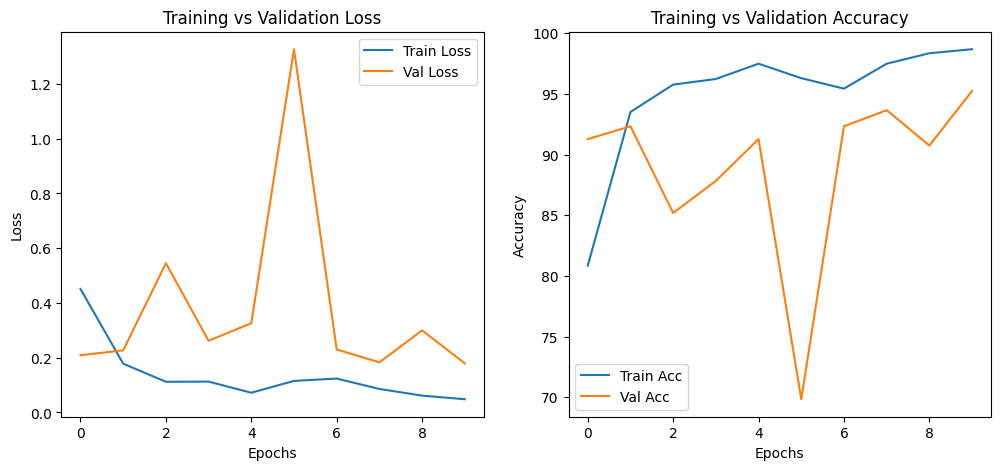

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


In [9]:
from sklearn.metrics import classification_report

# Function to generate classification report
def generate_classification_report(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Generate and print classification report
    report = classification_report(y_true, y_pred, target_names=test_data.classes)
    print("\nClassification Report:\n", report)

# Call function to generate classification report
generate_classification_report(model, test_loader)



Classification Report:
               precision    recall  f1-score   support

        fire       0.96      0.96      0.96       159
      nofire       0.97      0.98      0.97       251

    accuracy                           0.97       410
   macro avg       0.97      0.97      0.97       410
weighted avg       0.97      0.97      0.97       410



/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


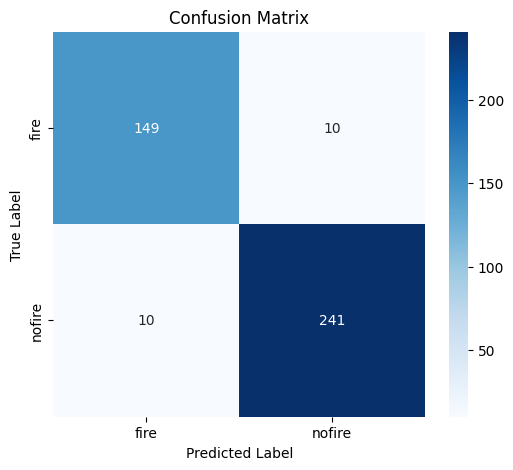

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to generate and plot confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.classes, yticklabels=test_data.classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Call function to generate confusion matrix
plot_confusion_matrix(model, test_loader)


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (96631920 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (94487082 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (101859328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


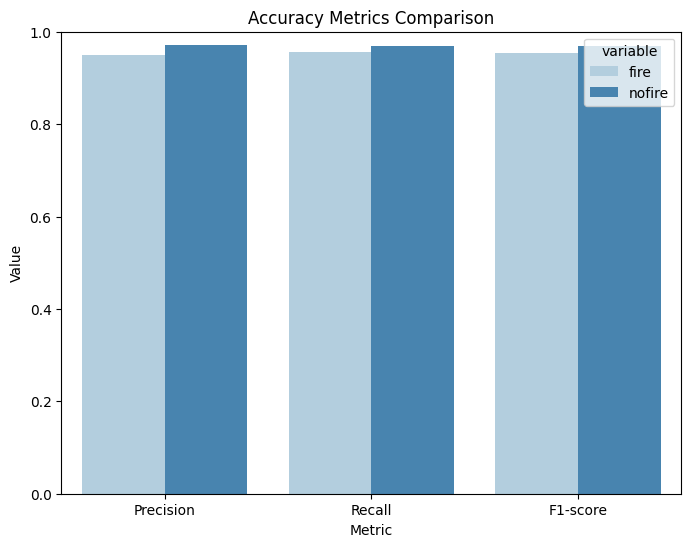

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report

# Function to get classification report values
def get_classification_report(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=test_data.classes, output_dict=True)

    return report

# Get classification report
report = get_classification_report(model, test_loader)

# Extract precision, recall, and f1-score
metrics = ["precision", "recall", "f1-score"]
classes = list(test_data.classes)

data = []
for metric in metrics:
    for class_label in classes:
        data.append({"Metric": metric.capitalize(), "value": report[class_label][metric], "variable": class_label})

# Create DataFrame
df = pd.DataFrame(data)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x="Metric", y="value", hue="variable", data=df, palette="Blues")

plt.xlabel("Metric")
plt.ylabel("Value")
plt.title("Accuracy Metrics Comparison")
plt.ylim(0, 1)  # Ensure values are between 0 and 1
plt.legend(title="variable")

plt.show()
